[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/03_sampling_the_imaginary.ipynb)

# Chapter 3 - Sampling the Imaginary

## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz
    
USE_NIGHTLY_TFP = True # @param
if IN_COLAB and USE_NIGHTLY_TFP:
    !pip install --upgrade tf-nightly
    !pip install --upgrade tfp-nightly

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.2
tensorflow 2.2.0-dev20200417
tensorflow_probability 0.11.0-dev20200417
arviz 0.7.0
scipy 1.4.1
pandas 1.0.3


In [5]:
if not USE_NIGHTLY_TFP:
  assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
  assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

In [6]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

## Code 3.1

In [7]:
Pr_Positive_Vampire = 0.95
Pr_Positive_Mortal = 0.01
Pr_Vampire = 0.001
tmp = Pr_Positive_Vampire * Pr_Vampire
Pr_Positive = tmp + Pr_Positive_Mortal * (1 - Pr_Vampire)
Pr_Vampire_Positive = tmp / Pr_Positive
Pr_Vampire_Positive

0.08683729433272395

## Code 3.2

In [8]:
p_grid = tf.linspace(start=0.0001, stop=0.99999, num=1000)
prob_p = tf.repeat(1., 1000)
prob_data = tf.exp(tfd.Binomial(total_count=9, probs=p_grid).log_prob(6))
joint_prob = prob_data * prob_p
posterior = joint_prob / tf.reduce_sum(joint_prob)

## Code 3.3

In [9]:
samples = tfd.Categorical(probs=posterior).sample(10_000)
sample_rows = p_grid.numpy()[samples]

## Code 3.4

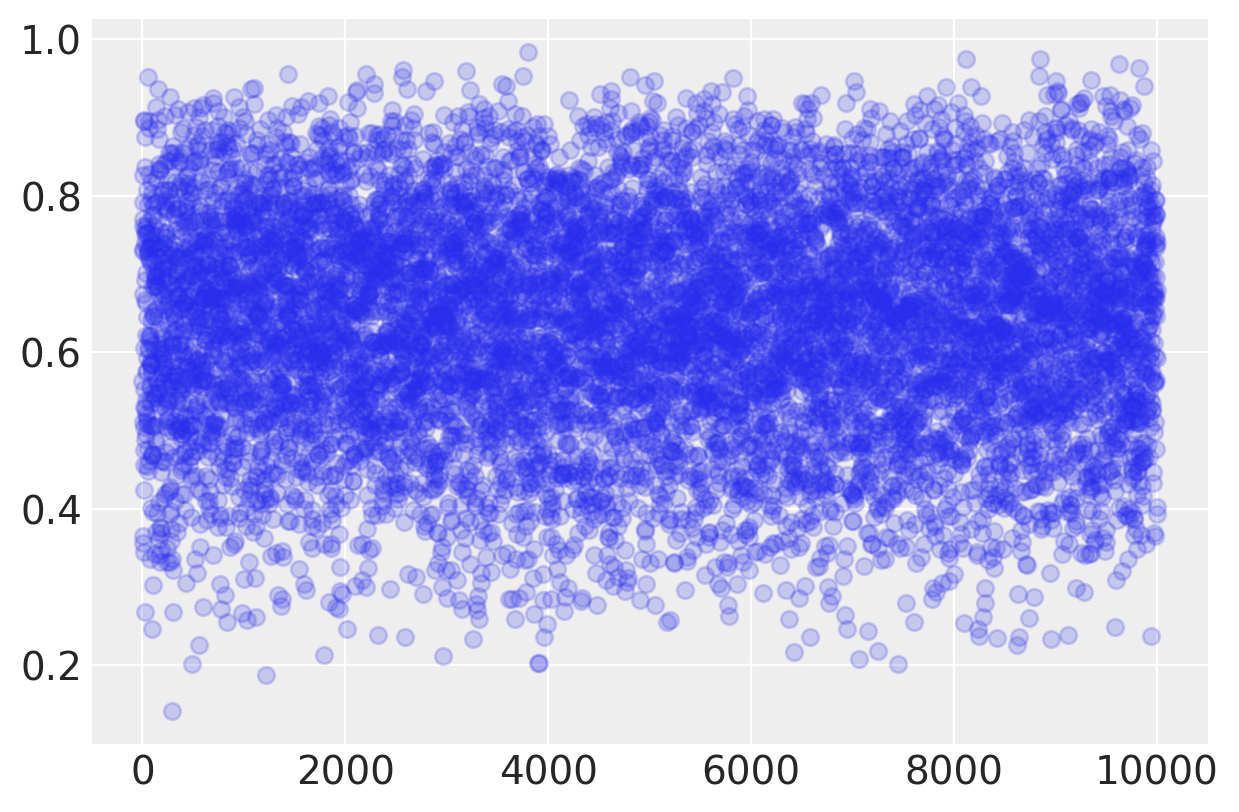

In [10]:
plt.scatter(range(len(sample_rows)), sample_rows, alpha=0.2);

## Code 3.5

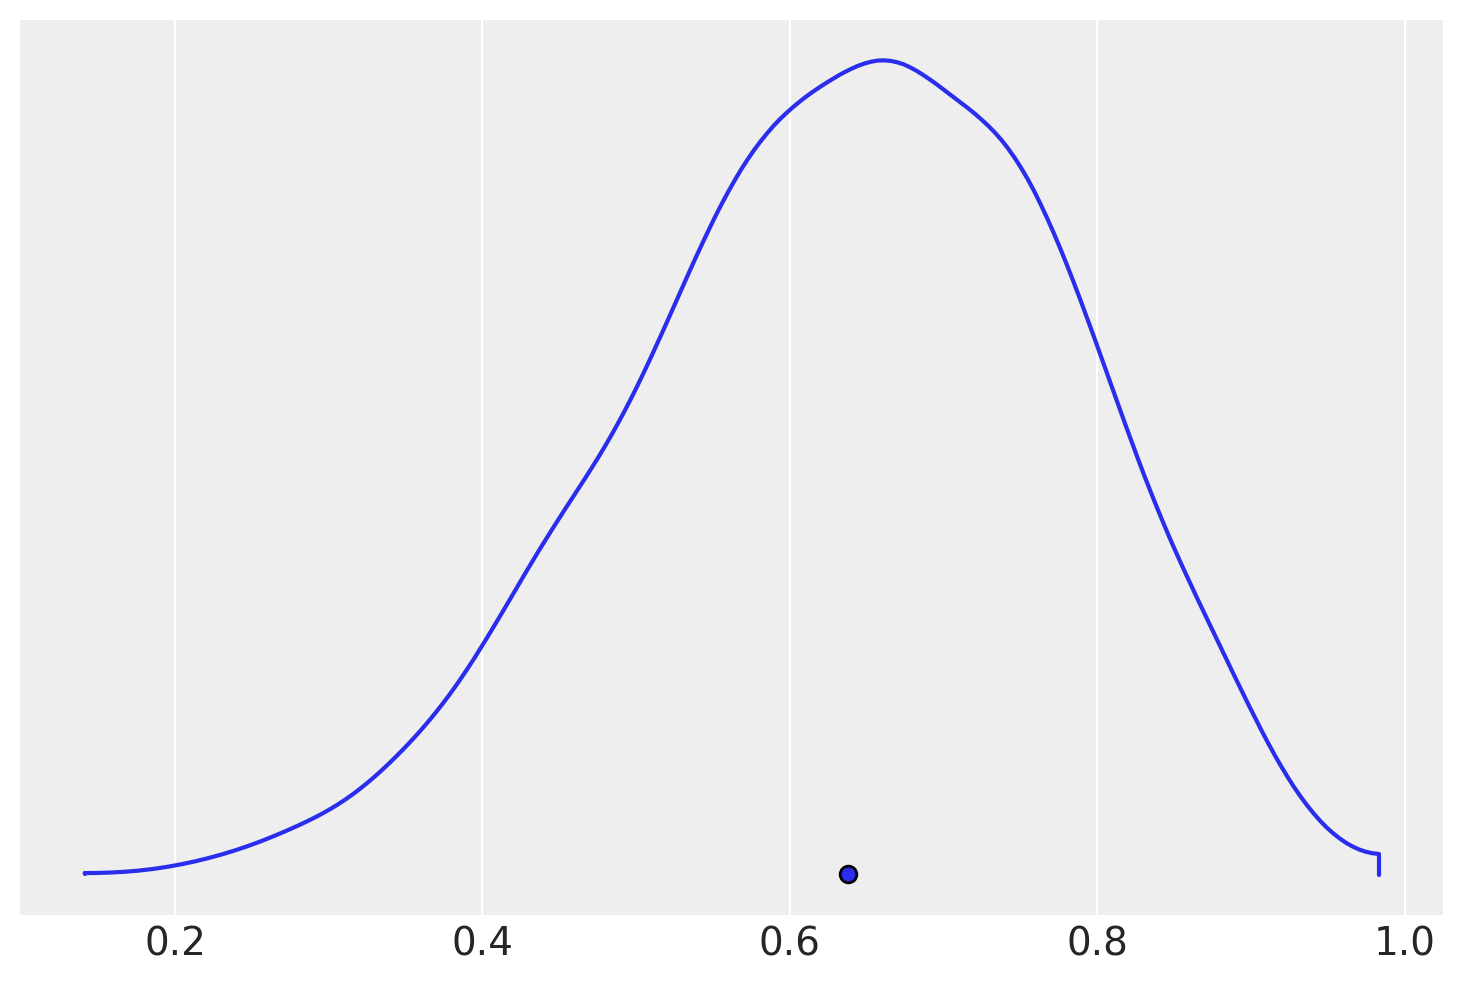

In [11]:
az.plot_density({"": sample_rows}, credible_interval=1);

## Code 3.6

In [12]:
tf.reduce_sum(posterior[p_grid < 0.5])

<tf.Tensor: shape=(), dtype=float32, numpy=0.1719484>

## Code 3.7

In [13]:
sum(sample_rows < 0.5) / 10_000

0.1661

## Code 3.8

In [14]:
sum((sample_rows > 0.5) & (sample_rows < 0.75)) / 10_000

0.6079

## Code 3.9

In [15]:
np.percentile(sample_rows, 80)

0.7607770562171936

## Code 3.10

In [16]:
np.percentile(sample_rows, [10, 90])

array([0.44949999, 0.81282341])

## Code 3.11

In [17]:
p_grid = tf.linspace(start=0.0001, stop=0.99999, num=1000)
prior = tf.repeat(1., 1000)
likelihood = tf.exp(tfd.Binomial(total_count=3, probs=p_grid).log_prob(3))
joint_prob = likelihood * prior
posterior = joint_prob / tf.reduce_sum(joint_prob)

samples = tfd.Categorical(probs=posterior).sample(10_000)
sample_rows = p_grid.numpy()[samples]

## Code 3.12

In [18]:
np.percentile(sample_rows, q=(25, 75))

array([0.70873076, 0.93192941])

## Code 3.13

In [19]:
az.hpd(sample_rows, credible_interval=0.5)

array([0.8418492, 0.99999  ], dtype=float32)

## Code 3.14

In [20]:
p_grid[posterior == max(posterior)]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.99999], dtype=float32)>

## Code 3.15

In [21]:
stats.mode(sample_rows)[0]

array([0.9769695], dtype=float32)

## Code 3.16

In [22]:
np.mean(sample_rows), np.median(sample_rows)

(0.80106044, 0.8418492)

## Code 3.17

In [23]:
sum(posterior * abs(0.5 - p_grid))

<tf.Tensor: shape=(), dtype=float32, numpy=0.3128676>

## Code 3.18 & 3.19

In [24]:
# loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
# p_grid[loss == min(loss)]

## Code 3.20

In [25]:
tf.exp(tfd.Binomial(total_count=2, probs=0.7).log_prob(np.arange(3)))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.09      , 0.42000002, 0.48999998], dtype=float32)>

## Code 3.21

In [26]:
tfd.Binomial(total_count=2, probs=0.7).sample()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

## Code 3.22

In [27]:
tfd.Binomial(total_count=2, probs=0.7).sample((10,))

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 2., 1., 1., 2., 2., 1., 2., 2., 1.], dtype=float32)>

## Code 3.23

In [28]:
dummy_w = tfd.Binomial(total_count=2, probs=0.7).sample((100000,))

np.unique(dummy_w.numpy(), return_counts=True)[1] / 1e5

array([0.09019, 0.41946, 0.49035])

## Code 3.24

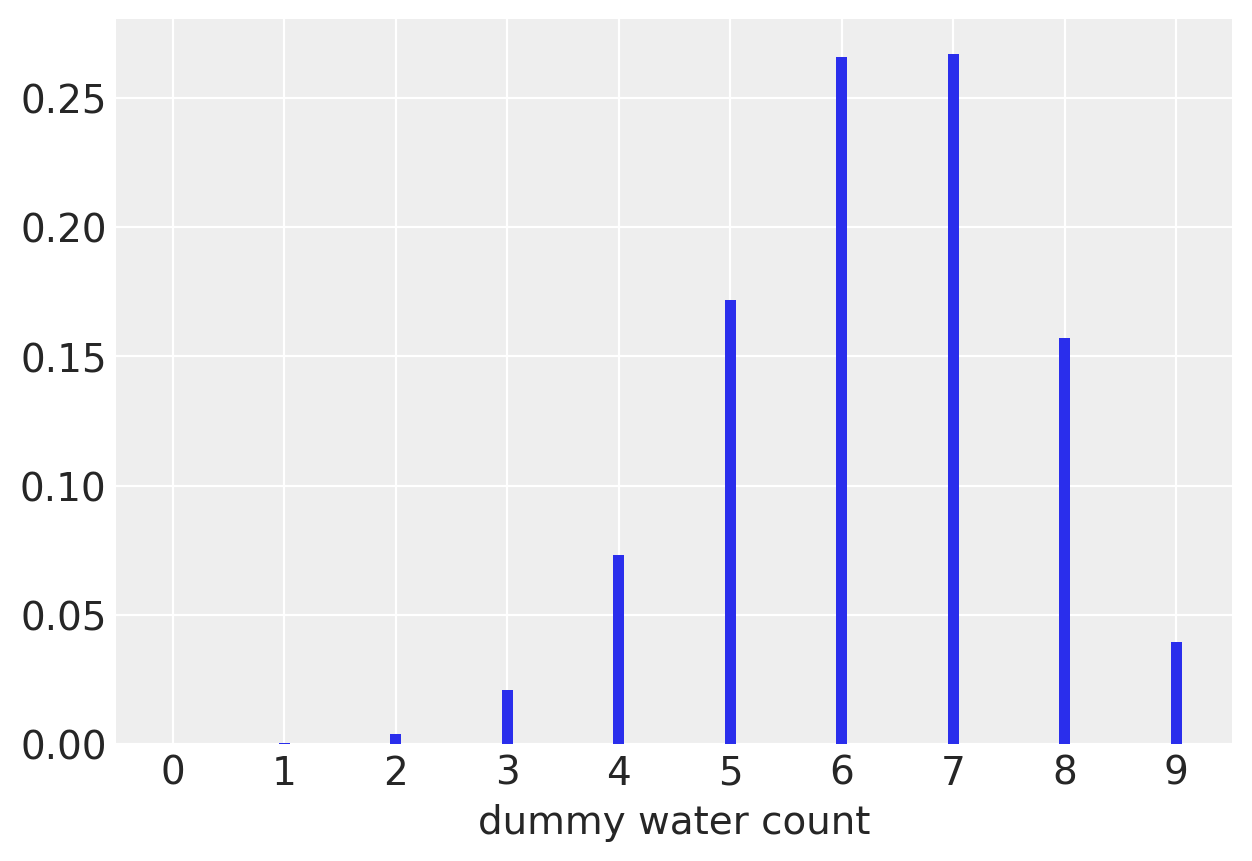

In [29]:
dummy_w = tfd.Binomial(total_count=9, probs=0.7).sample((100000,))
ax = az.plot_dist(dummy_w.numpy(), kind='hist', hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14);

## Code 3.25

In [30]:
w = tfd.Binomial(total_count=9, probs=0.6).sample((int(1e4),))

## Code 3.26

In [31]:
w = tfd.Binomial(total_count=9, probs=sample_rows).sample()

## Code 3.27

In [32]:
p_grid = tf.linspace(start=0.001, stop=0.9999, num=1000)
prior = tf.repeat(1., 1000)
likelihood = tf.exp(tfd.Binomial(total_count=9, probs=p_grid).log_prob(6))
joint_prob = likelihood * prior
posterior = joint_prob / tf.reduce_sum(joint_prob)

sample_rows = p_grid.numpy()[tfd.Categorical(posterior).sample((10000,))]

## Code 3.28

In [33]:
birth1 = [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
          0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
          0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
          0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
          1, 1, 1, 0, 1, 1, 1, 1]
birth2 = [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
          1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
          1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
          0, 1, 1, 1, 0, 0, 0, 0]

## Code 3.29

In [34]:
sum(birth1) + sum(birth2)

111